In [1]:
# Data processing
import numpy as np
import pandas as pd

# Machine Learning
from scipy.spatial import distance
from scipy.stats import pearsonr
from numpy import linalg as LAnumpy
from sklearn.linear_model import LinearRegression

# Data display 
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

In [2]:
NB_BINS = 1258
EMBEDDING_SIZE = 3

In [3]:
def FISH_values_Tanizawa(filename):
    fish_table = pd.read_csv(filename, sep=";", header=0, names=None, dtype=float)
    temp = fish_table[['Chr1', 'StartChr1', 'Chr2', 'EndChr2', 'FISH_dist']]
    fish_distances = pd.DataFrame()
    fish_distances['Chr1'] = temp['Chr1'].astype(int)
    fish_distances['StartChr1'] = round(temp['StartChr1'] / 10000).astype(int)
    fish_distances['Chr2'] = temp['Chr2'].astype(int)
    fish_distances['EndChr2'] = round(temp['EndChr2'] / 10000).astype(int)
    fish_distances['FISH_dist'] = temp['FISH_dist']
    fish_distances.columns = ['Chr1', 'Loci1', 'Chr2', 'Loci2', 'FISH_dist']

    return fish_distances

In [4]:
def dist_Tanizawa_FISH(coordinates, fish_table):
    startChr=[0, 558, 1012]  
    
    ratio = 1
    reconstr_dist = []
    for i in fish_table.index.values.tolist():
        chr1 = fish_table['Chr1'][i]
        chr2 = fish_table['Chr2'][i]
        loci1 = fish_table['Loci1'][i]
        loci2 = fish_table['Loci2'][i]
        dist_fish = fish_table['FISH_dist'][i]
        dist = distance.euclidean(coordinates[startChr[chr1-1] + loci1], coordinates[startChr[chr2-1] + loci2])
        reconstr_dist.append(dist)
        
    return reconstr_dist

In [5]:
def centralize_torch(z):
    return z - torch.repeat_interleave(torch.reshape(torch.mean(z, axis=1), (-1,1,EMBEDDING_SIZE)), NB_BINS, dim=1)

In [6]:
def normalize_torch(z):
    
    norms = LAtorch.norm(z, 2, dim=2)
    max_norms, _ = torch.max(norms, axis=1)
    max_norms = torch.reshape(max_norms, (BATCH_SIZE,1,1))
    max_norms = torch.repeat_interleave(max_norms, NB_BINS, dim=1)
    max_norms = torch.repeat_interleave(max_norms, EMBEDDING_SIZE, dim=2)
    max_norms[max_norms == 0] = 1
    
    return z / max_norms

In [7]:
def centralize_and_normalize_torch(z):
    
    # Translate
    z = centralize_torch(z)
    
    # Scale
    z = normalize_torch(z)
    
    return z

In [8]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [9]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [10]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [11]:
def kabsch_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)
    
    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d
    
    r = np.matmul(np.matmul(u, a), vh)
    
    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [12]:
def kabsch_distance_numpy(pred_structure, true_structure):
    
    pred_structure_unit_ball, true_structure_unit_ball = kabsch_superimposition_numpy(pred_structure, true_structure)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

In [13]:
fission_yeast_reach3d_structure_1 = \
    np.loadtxt('../previous_work/reach3D/reach3d_fission_yeast_output_structure_1.txt', dtype='f', delimiter='\t')
fission_yeast_reach3d_structure_2 = \
    np.loadtxt('../previous_work/reach3D/reach3d_fission_yeast_output_structure_2.txt', dtype='f', delimiter='\t')
fission_yeast_reach3d_structure_3 = \
    np.loadtxt('../previous_work/reach3D/reach3d_fission_yeast_output_structure_3.txt', dtype='f', delimiter='\t')
fission_yeast_reach3d_structure_4 = \
    np.loadtxt('../previous_work/reach3D/reach3d_fission_yeast_output_structure_4.txt', dtype='f', delimiter='\t')
fission_yeast_reach3d_structure_5 = \
    np.loadtxt('../previous_work/reach3D/reach3d_fission_yeast_output_structure_5.txt', dtype='f', delimiter='\t')

fission_yeast_minimds_structure_1 = \
        np.loadtxt('../previous_work/minimds/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_1.txt', dtype='f', delimiter=' ')
fission_yeast_minimds_structure_1 = np.nan_to_num(fission_yeast_minimds_structure_1, 0)
fission_yeast_minimds_structure_2 = \
        np.loadtxt('../previous_work/minimds/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_2.txt', dtype='f', delimiter=' ')
fission_yeast_minimds_structure_2 = np.nan_to_num(fission_yeast_minimds_structure_2, 0)
fission_yeast_minimds_structure_3 = \
        np.loadtxt('../previous_work/minimds/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_3.txt', dtype='f', delimiter=' ')
fission_yeast_minimds_structure_3 = np.nan_to_num(fission_yeast_minimds_structure_3, 0)
fission_yeast_minimds_structure_4 = \
        np.loadtxt('../previous_work/minimds/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_4.txt', dtype='f', delimiter=' ')
fission_yeast_minimds_structure_4 = np.nan_to_num(fission_yeast_minimds_structure_4, 0)
fission_yeast_minimds_structure_5 = \
        np.loadtxt('../previous_work/minimds/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_5.txt', dtype='f', delimiter=' ')
fission_yeast_minimds_structure_5 = np.nan_to_num(fission_yeast_minimds_structure_5, 0)

fission_yeast_gem_structure_1 = \
        np.loadtxt('../previous_work/gem/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_10k_confo_1.txt', dtype='f', delimiter='\t')
fission_yeast_gem_structure_2 = \
        np.loadtxt('../previous_work/gem/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_10k_confo_2.txt', dtype='f', delimiter='\t')
fission_yeast_gem_structure_3 = \
        np.loadtxt('../previous_work/gem/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_10k_confo_3.txt', dtype='f', delimiter='\t')
fission_yeast_gem_structure_4 = \
        np.loadtxt('../previous_work/gem/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_10k_confo_4.txt', dtype='f', delimiter='\t')
fission_yeast_gem_structure_5 = \
        np.loadtxt('../previous_work/gem/data/fission_yeast/fission_yeast_structure_formatted/fission_yeast_structure_formatted_10k_confo_5.txt', dtype='f', delimiter='\t')

fission_yeast_tech3d_structure_1 = \
        np.loadtxt('../previous_work/tech_3d/data/fission_yeast/structures/synthetic_random_fission_yeast_linear_fission_yeast_test_structure_10k_1.txt', dtype='f', delimiter=' ')
fission_yeast_tech3d_structure_2 = \
        np.loadtxt('../previous_work/tech_3d/data/fission_yeast/structures/synthetic_random_fission_yeast_linear_fission_yeast_test_structure_10k_2.txt', dtype='f', delimiter=' ')
fission_yeast_tech3d_structure_3 = \
        np.loadtxt('../previous_work/tech_3d/data/fission_yeast/structures/synthetic_random_fission_yeast_linear_fission_yeast_test_structure_10k_3.txt', dtype='f', delimiter=' ')
fission_yeast_tech3d_structure_4 = \
        np.loadtxt('../previous_work/tech_3d/data/fission_yeast/structures/synthetic_random_fission_yeast_linear_fission_yeast_test_structure_10k_4.txt', dtype='f', delimiter=' ')
fission_yeast_tech3d_structure_5 = \
        np.loadtxt('../previous_work/tech_3d/data/fission_yeast/structures/synthetic_random_fission_yeast_linear_fission_yeast_test_structure_10k_5.txt', dtype='f', delimiter=' ')

fission_yeast_chrom_structure_1 = np.loadtxt('../saved_results/synthetic_random_fission_yeast/trans/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_1.txt', dtype='f', delimiter= ' ')
fission_yeast_chrom_structure_2 = np.loadtxt('../saved_results/synthetic_random_fission_yeast/trans/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_2.txt', dtype='f', delimiter= ' ')
fission_yeast_chrom_structure_3 = np.loadtxt('../saved_results/synthetic_random_fission_yeast/trans/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_3.txt', dtype='f', delimiter= ' ')
fission_yeast_chrom_structure_4 = np.loadtxt('../saved_results/synthetic_random_fission_yeast/trans/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_4.txt', dtype='f', delimiter= ' ')
fission_yeast_chrom_structure_5 = np.loadtxt('../saved_results/synthetic_random_fission_yeast/trans/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_5.txt', dtype='f', delimiter= ' ')



In [14]:
fission_yeast_reach3d_structure_1 = centralize_and_normalize_numpy(fission_yeast_reach3d_structure_1)
fission_yeast_reach3d_structure_2 = centralize_and_normalize_numpy(fission_yeast_reach3d_structure_2)
fission_yeast_reach3d_structure_3 = centralize_and_normalize_numpy(fission_yeast_reach3d_structure_3)
fission_yeast_reach3d_structure_4 = centralize_and_normalize_numpy(fission_yeast_reach3d_structure_4)
fission_yeast_reach3d_structure_5 = centralize_and_normalize_numpy(fission_yeast_reach3d_structure_5)


fission_yeast_minimds_structure_1 = centralize_and_normalize_numpy(fission_yeast_minimds_structure_1)
fission_yeast_minimds_structure_2 = centralize_and_normalize_numpy(fission_yeast_minimds_structure_2)
fission_yeast_minimds_structure_3 = centralize_and_normalize_numpy(fission_yeast_minimds_structure_3)
fission_yeast_minimds_structure_4 = centralize_and_normalize_numpy(fission_yeast_minimds_structure_4)
fission_yeast_minimds_structure_5 = centralize_and_normalize_numpy(fission_yeast_minimds_structure_5)


fission_yeast_gem_structure_1 = centralize_and_normalize_numpy(fission_yeast_gem_structure_1)
fission_yeast_gem_structure_2 = centralize_and_normalize_numpy(fission_yeast_gem_structure_2)
fission_yeast_gem_structure_3 = centralize_and_normalize_numpy(fission_yeast_gem_structure_3)
fission_yeast_gem_structure_4 = centralize_and_normalize_numpy(fission_yeast_gem_structure_4)
fission_yeast_gem_structure_5 = centralize_and_normalize_numpy(fission_yeast_gem_structure_5)

fission_yeast_tech3d_structure_1 = centralize_and_normalize_numpy(fission_yeast_tech3d_structure_1)
fission_yeast_tech3d_structure_2 = centralize_and_normalize_numpy(fission_yeast_tech3d_structure_2)
fission_yeast_tech3d_structure_3 = centralize_and_normalize_numpy(fission_yeast_tech3d_structure_3)
fission_yeast_tech3d_structure_4 = centralize_and_normalize_numpy(fission_yeast_tech3d_structure_4)
fission_yeast_tech3d_structure_5 = centralize_and_normalize_numpy(fission_yeast_tech3d_structure_5)

fission_yeast_chrom_structure_1 = centralize_and_normalize_numpy(fission_yeast_chrom_structure_1)
fission_yeast_chrom_structure_2 = centralize_and_normalize_numpy(fission_yeast_chrom_structure_2)
fission_yeast_chrom_structure_3 = centralize_and_normalize_numpy(fission_yeast_chrom_structure_3)
fission_yeast_chrom_structure_4 = centralize_and_normalize_numpy(fission_yeast_chrom_structure_4)
fission_yeast_chrom_structure_5 = centralize_and_normalize_numpy(fission_yeast_chrom_structure_5)

In [15]:
def random_prediction(nb_bins):
    
    # Random r's
    r_s = np.random.uniform(low=0, high=1, size=nb_bins)
    
    # Random theta's
    theta_s = np.random.uniform(low=0, high=np.pi, size=nb_bins)
    
    # Random phi's
    phi_s = np.random.uniform(low=0, high=2*np.pi, size=nb_bins)
    
    final_structure = []
    for i in range(nb_bins):
        x = r_s[i] * np.cos(phi_s[i]) * np.sin(theta_s[i])
        y = r_s[i] * np.sin(phi_s[i]) * np.sin(theta_s[i])
        z = r_s[i] * np.cos(theta_s[i])
        final_structure.append([x, y, z])
        
    return np.asarray(final_structure).reshape((nb_bins, EMBEDDING_SIZE))

In [16]:
fission_yeast_random_structure = random_prediction(NB_BINS)

In [ ]:
#dist_gem_2,  dist_minimds_1, dist_tech3d_2, dist_reach3d_5, dist_chrom_1

In [44]:
#display_structure = fission_yeast_reach3d_structure
display_structure = fission_yeast_chrom_structure_1

In [45]:
color = np.full(len(display_structure[:,0]), 'some non specified color')
color[:558] = 'red'
color[558:1012] = 'green'
color[1012:] = 'blue'

In [46]:
# Initialize figure with 3D subplots
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=display_structure[:,0], y=display_structure[:,1], z=display_structure[:,2], opacity=0.7,
    marker=dict(
        size=6,
        color= color, #np.asarray(range(len(display_structure[:,0]))),
        colorscale='Viridis',
        line=dict(width=3)
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=1)

fig.update_layout(
    height=1000,
    width=1000
)

fig.show()

In [20]:
fish_table = FISH_values_Tanizawa('../../data/fission_yeast/FISH_Tanizawa.csv')
fish_table

,Chr1,Loci1,Chr2,Loci2,FISH_dist
0,1,76,1,71,0.162
1,2,316,2,312,0.173
2,3,155,3,144,0.171
3,1,164,1,151,0.220
4,1,175,1,151,0.280
5,1,481,1,438,0.355
6,1,149,1,79,0.343
7,1,85,1,20,0.381
8,2,217,2,189,0.363
9,1,303,1,151,0.373


In [21]:
dist_fish = list(fish_table['FISH_dist'])

In [22]:

dist_reach3d_1 = dist_Tanizawa_FISH(fission_yeast_reach3d_structure_1, fish_table)
dist_reach3d_2 = dist_Tanizawa_FISH(fission_yeast_reach3d_structure_2, fish_table)
dist_reach3d_3 = dist_Tanizawa_FISH(fission_yeast_reach3d_structure_3, fish_table)
dist_reach3d_4 = dist_Tanizawa_FISH(fission_yeast_reach3d_structure_4, fish_table)
dist_reach3d_5 = dist_Tanizawa_FISH(fission_yeast_reach3d_structure_5, fish_table)


dist_minimds_1 = dist_Tanizawa_FISH(fission_yeast_minimds_structure_1, fish_table)
dist_minimds_2 = dist_Tanizawa_FISH(fission_yeast_minimds_structure_2, fish_table)
dist_minimds_3 = dist_Tanizawa_FISH(fission_yeast_minimds_structure_3, fish_table)
dist_minimds_4 = dist_Tanizawa_FISH(fission_yeast_minimds_structure_4, fish_table)
dist_minimds_5 = dist_Tanizawa_FISH(fission_yeast_minimds_structure_5, fish_table)

dist_gem_1 = dist_Tanizawa_FISH(fission_yeast_gem_structure_1, fish_table)
dist_gem_2 = dist_Tanizawa_FISH(fission_yeast_gem_structure_2, fish_table)
dist_gem_3 = dist_Tanizawa_FISH(fission_yeast_gem_structure_3, fish_table)
dist_gem_4 = dist_Tanizawa_FISH(fission_yeast_gem_structure_4, fish_table)
dist_gem_5 = dist_Tanizawa_FISH(fission_yeast_gem_structure_5, fish_table)

dist_tech3d_1 = dist_Tanizawa_FISH(fission_yeast_tech3d_structure_1, fish_table)
dist_tech3d_2 = dist_Tanizawa_FISH(fission_yeast_tech3d_structure_2, fish_table)
dist_tech3d_3 = dist_Tanizawa_FISH(fission_yeast_tech3d_structure_3, fish_table)
dist_tech3d_4 = dist_Tanizawa_FISH(fission_yeast_tech3d_structure_4, fish_table)
dist_tech3d_5 = dist_Tanizawa_FISH(fission_yeast_tech3d_structure_5, fish_table)

dist_chrom_1 = dist_Tanizawa_FISH(fission_yeast_chrom_structure_1, fish_table)
dist_chrom_2 = dist_Tanizawa_FISH(fission_yeast_chrom_structure_2, fish_table)
dist_chrom_3 = dist_Tanizawa_FISH(fission_yeast_chrom_structure_3, fish_table)
dist_chrom_4 = dist_Tanizawa_FISH(fission_yeast_chrom_structure_4, fish_table)
dist_chrom_5 = dist_Tanizawa_FISH(fission_yeast_chrom_structure_5, fish_table)

dist_random = dist_Tanizawa_FISH(fission_yeast_random_structure, fish_table)

In [23]:
reach_fiss_array = [pearsonr(dist_fish, dist_reach3d_1)[0], pearsonr(dist_fish, dist_reach3d_2)[0], pearsonr(dist_fish, dist_reach3d_3)[0], pearsonr(dist_fish, dist_reach3d_4)[0], pearsonr(dist_fish, dist_reach3d_5)[0]]

mds_fiss_array = [pearsonr(dist_fish, dist_minimds_1)[0], pearsonr(dist_fish, dist_minimds_2)[0], pearsonr(dist_fish, dist_minimds_3)[0], pearsonr(dist_fish, dist_minimds_4)[0], pearsonr(dist_fish, dist_minimds_5)[0]]

gem_fiss_array = [pearsonr(dist_fish, dist_gem_1)[0], pearsonr(dist_fish, dist_gem_2)[0], pearsonr(dist_fish, dist_gem_3)[0], pearsonr(dist_fish, dist_gem_4)[0], pearsonr(dist_fish, dist_gem_5)[0]]

tech_fiss_array = [pearsonr(dist_fish, dist_tech3d_1)[0], pearsonr(dist_fish, dist_tech3d_2)[0], pearsonr(dist_fish, dist_tech3d_3)[0], pearsonr(dist_fish, dist_tech3d_4)[0], pearsonr(dist_fish, dist_tech3d_5)[0]]

chrom_fiss_array = [pearsonr(dist_fish, dist_chrom_1)[0], pearsonr(dist_fish, dist_chrom_2)[0], pearsonr(dist_fish, dist_chrom_3)[0], pearsonr(dist_fish, dist_chrom_4)[0], pearsonr(dist_fish, dist_chrom_5)[0]]

print(pearsonr(dist_fish, dist_random))

(0.6611624276883544, 0.0028107693727641068)


In [24]:
print(np.mean(gem_fiss_array))
print(np.var(gem_fiss_array))
print(np.median(gem_fiss_array))
print(np.min(gem_fiss_array))
print(np.max(gem_fiss_array))
print(np.argmax(gem_fiss_array))

0.8345859649256402
0.0012097627594703242
0.8287881706474424
0.7828280066063209
0.8752831894542332
1


In [25]:
print(np.mean(mds_fiss_array))
print(np.var(mds_fiss_array))
print(np.median(mds_fiss_array))
print(np.min(mds_fiss_array))
print(np.max(mds_fiss_array))
print(np.argmax(mds_fiss_array))

0.8874129084758019
0.0020240407907489008
0.9096689875655092
0.7974457914528994
0.9109964779630673
0


In [26]:
print(np.mean(reach_fiss_array))
print(np.var(reach_fiss_array))
print(np.median(reach_fiss_array))
print(np.min(reach_fiss_array))
print(np.max(reach_fiss_array))
print(np.argmax(reach_fiss_array))

0.5657180133158317
0.012029994275438022
0.6056851264230666
0.419429496762191
0.7212661996310665
4


In [27]:
print(np.mean(tech_fiss_array))
print(np.var(tech_fiss_array))
print(np.median(tech_fiss_array))
print(np.min(tech_fiss_array))
print(np.max(tech_fiss_array))
print(np.argmax(tech_fiss_array))

0.7709562595164744
0.001757218271485379
0.7745188896922229
0.7034102996854619
0.8258580394521265
3


In [28]:
print(np.mean(chrom_fiss_array))
print(np.var(chrom_fiss_array))
print(np.median(chrom_fiss_array))
print(np.min(chrom_fiss_array))
print(np.max(chrom_fiss_array))
print(np.argmax(chrom_fiss_array))

0.8845635135899826
0.0001790149335205658
0.8818330262134739
0.866570563631611
0.9075190796437809
0


In [29]:
SIZE = 200
LINEWIDTH = 3

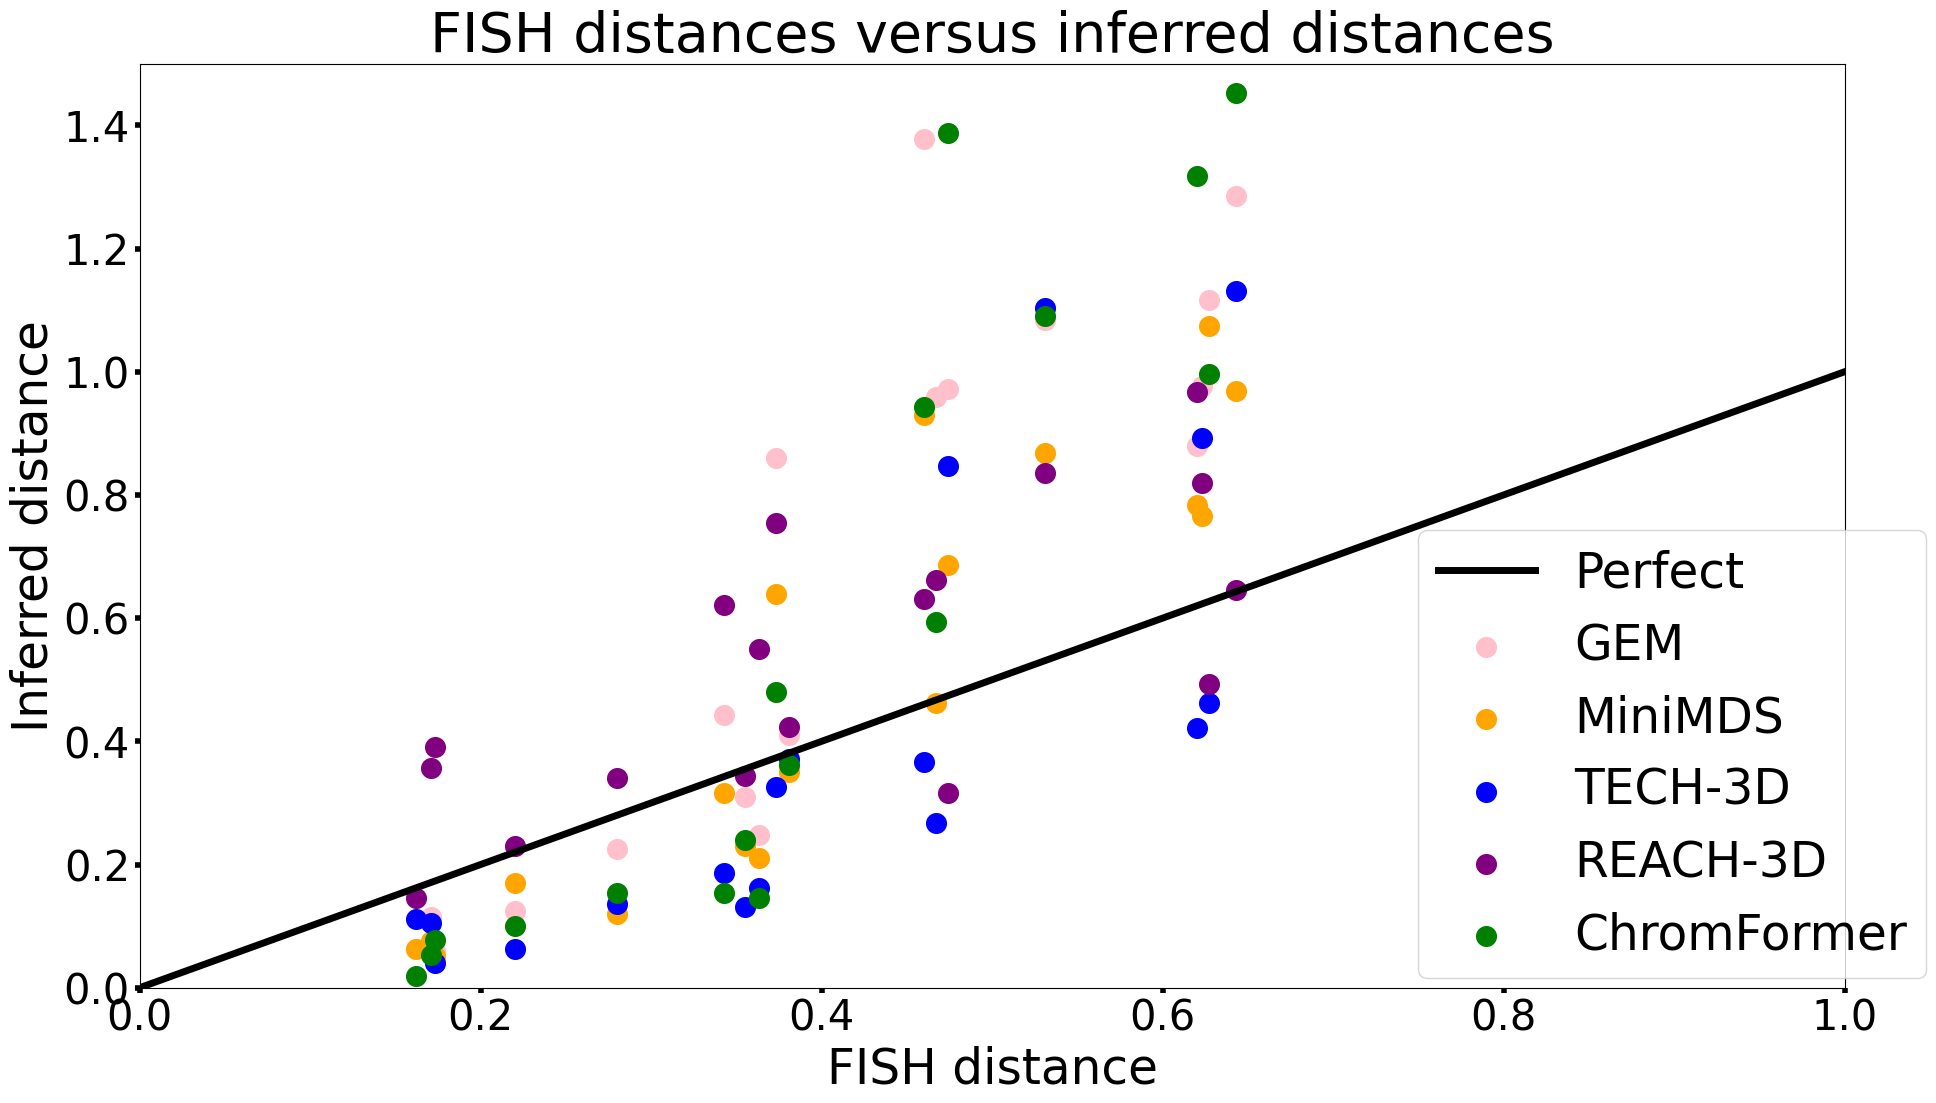

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(22,12))

axs.plot([0,1], [0,1], color='black', linewidth=5, label='Perfect')
axs.scatter(dist_fish, dist_gem_2, s=SIZE, color= 'pink', label='GEM')
axs.scatter(dist_fish, dist_minimds_1, s=SIZE, color= 'orange', label='MiniMDS')
axs.scatter(dist_fish, dist_tech3d_2, s=SIZE, color='blue', label='TECH-3D')
axs.scatter(dist_fish, dist_reach3d_5, s=SIZE, color= 'purple', label='REACH-3D')
axs.scatter(dist_fish, dist_chrom_1, s=SIZE, color= 'green', label='ChromFormer')

axs.set_title('FISH distances versus inferred distances', size=40)
axs.set_xlabel('FISH distance', fontsize = 35)
axs.set_ylabel('Inferred distance', fontsize = 35)
axs.tick_params(axis='both', which='major', labelsize=30, width=4)


axs.set_xlim(0, 1)
axs.set_ylim(0, 1.5)

plt.legend(fontsize=35, loc=(0.75, 0.01))

plt.savefig('fission_yeast_fish_distances_versus_inferred_distances.png')
plt.show()